In [1]:
from __future__ import division
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from numpy import inf
from math import sqrt
import os.path
import glob
from glob import iglob, glob

In [2]:
# data directory
ptc_dir = '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/'

### Gain calculation

In [3]:
flat_pattern = ptc_dir + 'flat/image0*.fits'
flatlist = sorted(set(glob(flat_pattern)))
flatlist

['/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000000.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000001.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000002.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000003.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000004.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000005.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000006.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000007.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000008.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/flat/image000009.fits',
 '/Users/c

In [4]:
bias_pattern = ptc_dir + 'bias/image0*.fits'
biaslist = sorted(set(glob(bias_pattern)))
biaslist

['/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000000.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000001.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000002.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000003.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000004.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000005.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000006.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000007.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000008.fits',
 '/Users/caridlin/Documents/Fireball thermal system/Detector system/ptc_S2/bias/image000009.fits',
 '/Users/c

In [5]:
# used in PTC plot
signallist = []    # average signal, in ADU/DN units
variance = []      # total noise (except for fixed pattern noise, or RN + shot noise), in [ADU/DN]**2 units

# used in gain plot
gainlist = []      # used in gain plot
signal = []        # signal (bias removed), in ADU/DN units, used in gain plot

# # only used for outputs
# readnoiselist = [] # readnoise, RN, in ADU/DN units

# region parameters on the detector, could be adjusted for specific system
n = 50
yregions = np.arange(200,1900,n)
xregions = [1150,2100]
xregions_b = [1150,2100]
# xregions = [1350,1900]
# xregions_b = [1350,1900]
print('Number of pixels in the region = ', n * (xregions[1] - xregions[0]))

Number of pixels in the region =  47500


In [6]:
# #master_bias = np.median([fits.getdata(i) for i in biaslist], axis = 0)
# bias = np.median([fits.getdata(i) for i in biaslist])

In [7]:
# plt.figure()
# plt.imshow(master_bias, origin = 'lower',  cmap = 'RdBu_r', aspect = 1, vmin = 699, vmax = 705)

In [8]:
# master_bias.shape

In [9]:
j = 0
for i in range(0,(len(flatlist)),3):
    # if all the biases are already used, reset j to 0 and start from the beginning in the biaslist
    if j > len(biaslist) - 1:
        j = 0
    imageb1 = np.array(fits.getdata(biaslist[j]))
    imageb2 = np.array(fits.getdata(biaslist[j + 1]))
    imageb1 = imageb1 * 1.0
    imageb2 = imageb2 * 1.0

    imagef1 = np.array(fits.getdata(flatlist[i]))
    imagef2 = np.array(fits.getdata(flatlist[i + 1]))
    imagef1 = imagef1 * 1.0
    imagef2 = imagef2 * 1.0

    for k in yregions:    
        imagef1_sec = imagef1[k : k + n, xregions[0] : xregions[1]]
        imagef2_sec = imagef2[k : k + n, xregions[0] : xregions[1]]
        imageb1_sec = imageb1[k : k + n, xregions_b[0] : xregions_b[1]]
        imageb2_sec = imageb2[k : k + n, xregions_b[0] : xregions_b[1]]

        # to remove fixed pattern noise, subtract consecutive images taken with the same exposure time
        imagef12_sec = np.subtract(imagef1_sec, imagef2_sec)
        imageb12_sec = np.subtract(imageb1_sec, imageb2_sec)

        sigf1 = np.std(imagef1_sec)
        sigb1 = np.std(imageb1_sec)
        sigf12 = np.std(imagef12_sec)
        sigb12 = np.std(imageb12_sec)

        mf1 = np.mean(imagef1_sec) 
        mf2 = np.mean(imagef2_sec)
        mb1 = np.mean(imageb1_sec)
        mb2 = np.mean(imageb2_sec)
        
        # calculate total noise and average signal, y and x axes of the PTC
        average_signal = ((mf1 - mb1) + (mf2 - mb2))/2
        signal.append(average_signal)
        img_diff = (imagef1_sec - mb1) - (imagef2_sec - mb2)
        var = np.std(img_diff) ** 2
        variance.append(var / 2) # factor of 2 comes from fixed pattern noise
        
#         # How is this calculated?
#         # Number of generated ADU (mf1 + mf2 - mb1 - mb2) / 2
#         # Number of incident photo-electrons: frame1 - frame2 to eliminate the fixed pattern noise, 
#         # then the residual noise is 2 times (shot noise plus read noise), ignore readnoise for large flux.
#         # Note sigf12 ** 2 = var, mf1 + mf2 - mb1 - mb2 = average_signal * 2
#         #gain = ((mf1 + mf2 - mb1 - mb2) / (sigf12 ** 2))# - sigb12**2))
#         #gain = ((mf1 + mf2 - mb1 - mb2) / var)# - sigb12**2))
#         gain = average_signal / (var / 2)
#         readnoise = gain * sigb1
#         gainlist.append(gain)
#         readnoiselist.append(readnoise)
#         signallist.append((mf1 - mb1))
    
    j += 2

In [10]:
# gainlist
# readnoiselist
# signallist
# variance
# signal

signal = np.array(signal)
variance = np.array(variance)

signal_sort = np.sort(signal)
idx = signal.argsort()
variance_sort = variance[idx]

In [11]:
# signal_sort = signal_sort[variance_sort < 30]
# variance_sort = variance_sort[variance_sort < 30]

# variance_sort

In [12]:
from astropy.modeling import models,fitting
from astropy.modeling.models import custom_model

# Fitting with masked values in astropy
# Reference: https://docs.astropy.org/en/stable/modeling/fitting.html

# consider only below saturation
mask_idx = np.argmax(variance_sort)
k_ini = (variance_sort[int(mask_idx * 3 / 4)] - variance_sort[int(mask_idx * 1 / 4)]) / (signal_sort[int(mask_idx * 3 / 4)] - signal_sort[int(mask_idx * 1 / 4)])
RN_ini = abs(np.sqrt(variance_sort[0] - k_ini * signal_sort[0]) / k_ini)
print(RN_ini, k_ini)

# k stands for conversion gain


@custom_model
def PTC_var(x, RN = RN_ini, k = k_ini):
    return k ** 2 * RN ** 2 + k * x

fit = fitting.LevMarLSQFitter(calc_uncertainties=True)
ptc_var_ini = PTC_var()
f_para1 = fit(ptc_var_ini, signal_sort[:mask_idx], variance_sort[:mask_idx])
print(f_para1)
# print(f_para1.cov_matrix[0, 0])
# print(f_para1.cov_matrix[1, 1])

@custom_model
def PTC_std(x, RN = RN_ini, k = f_para1.k[0]):       
    return np.log10(np.sqrt(k ** 2 * RN ** 2 + k * 10 ** x))

signal_sort_log = np.log10(signal_sort[:mask_idx])
#signal_sort_log[np.isnan(signal_sort_log)] = 0
variance_sort_log = np.log10(np.sqrt(variance_sort[:mask_idx]))

mask = np.isfinite(signal_sort_log)

fit = fitting.LevMarLSQFitter(calc_uncertainties=True)
#ptc_std_ini = PTC_std(bounds={'k': (f_para1.k[0] - 5 * f_para1.cov_matrix[1, 1], f_para1.k[0] + 5 * f_para1.cov_matrix[1, 1])})
ptc_std_ini = PTC_std()
f_para2 = fit(ptc_std_ini, signal_sort_log[mask], variance_sort_log[mask])
print(f_para2)
# print(f_para2.cov_matrix[0, 0])
# print(f_para2.cov_matrix[1, 1])

################################################
##### Some old testing with liear fitting  #####
################################################

# fit = fitting.LinearLSQFitter(calc_uncertainties=True)
# line_init = models.Linear1D()
# f_para = fit(line_init, signal_sort[:mask_idx], variance_sort[:mask_idx])
# print(f_para)
# print(f_para.cov_matrix[0, 0])
# print(f_para.cov_matrix[1, 1])

# fit = fitting.LinearLSQFitter(calc_uncertainties=True)
# const_init = models.Const1D()
# f_para3 = fit(const_init, signal_sort[:mask_idx], np.sqrt(variance_sort[:mask_idx] - )
# print(f_para3)
# print(f_para3.cov_matrix[0, 0])
# print(f_para3.cov_matrix[1, 1])

38.81787489620771 0.05533219942405867
Model: PTC_var
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            RN                 k          
    ----------------- --------------------
    49.74454916299119 0.053368265515877686
Model: PTC_std
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            RN                  k         
    ------------------ -------------------
    35.085638968061076 0.05550264691691423


<IPython.core.display.Javascript object>


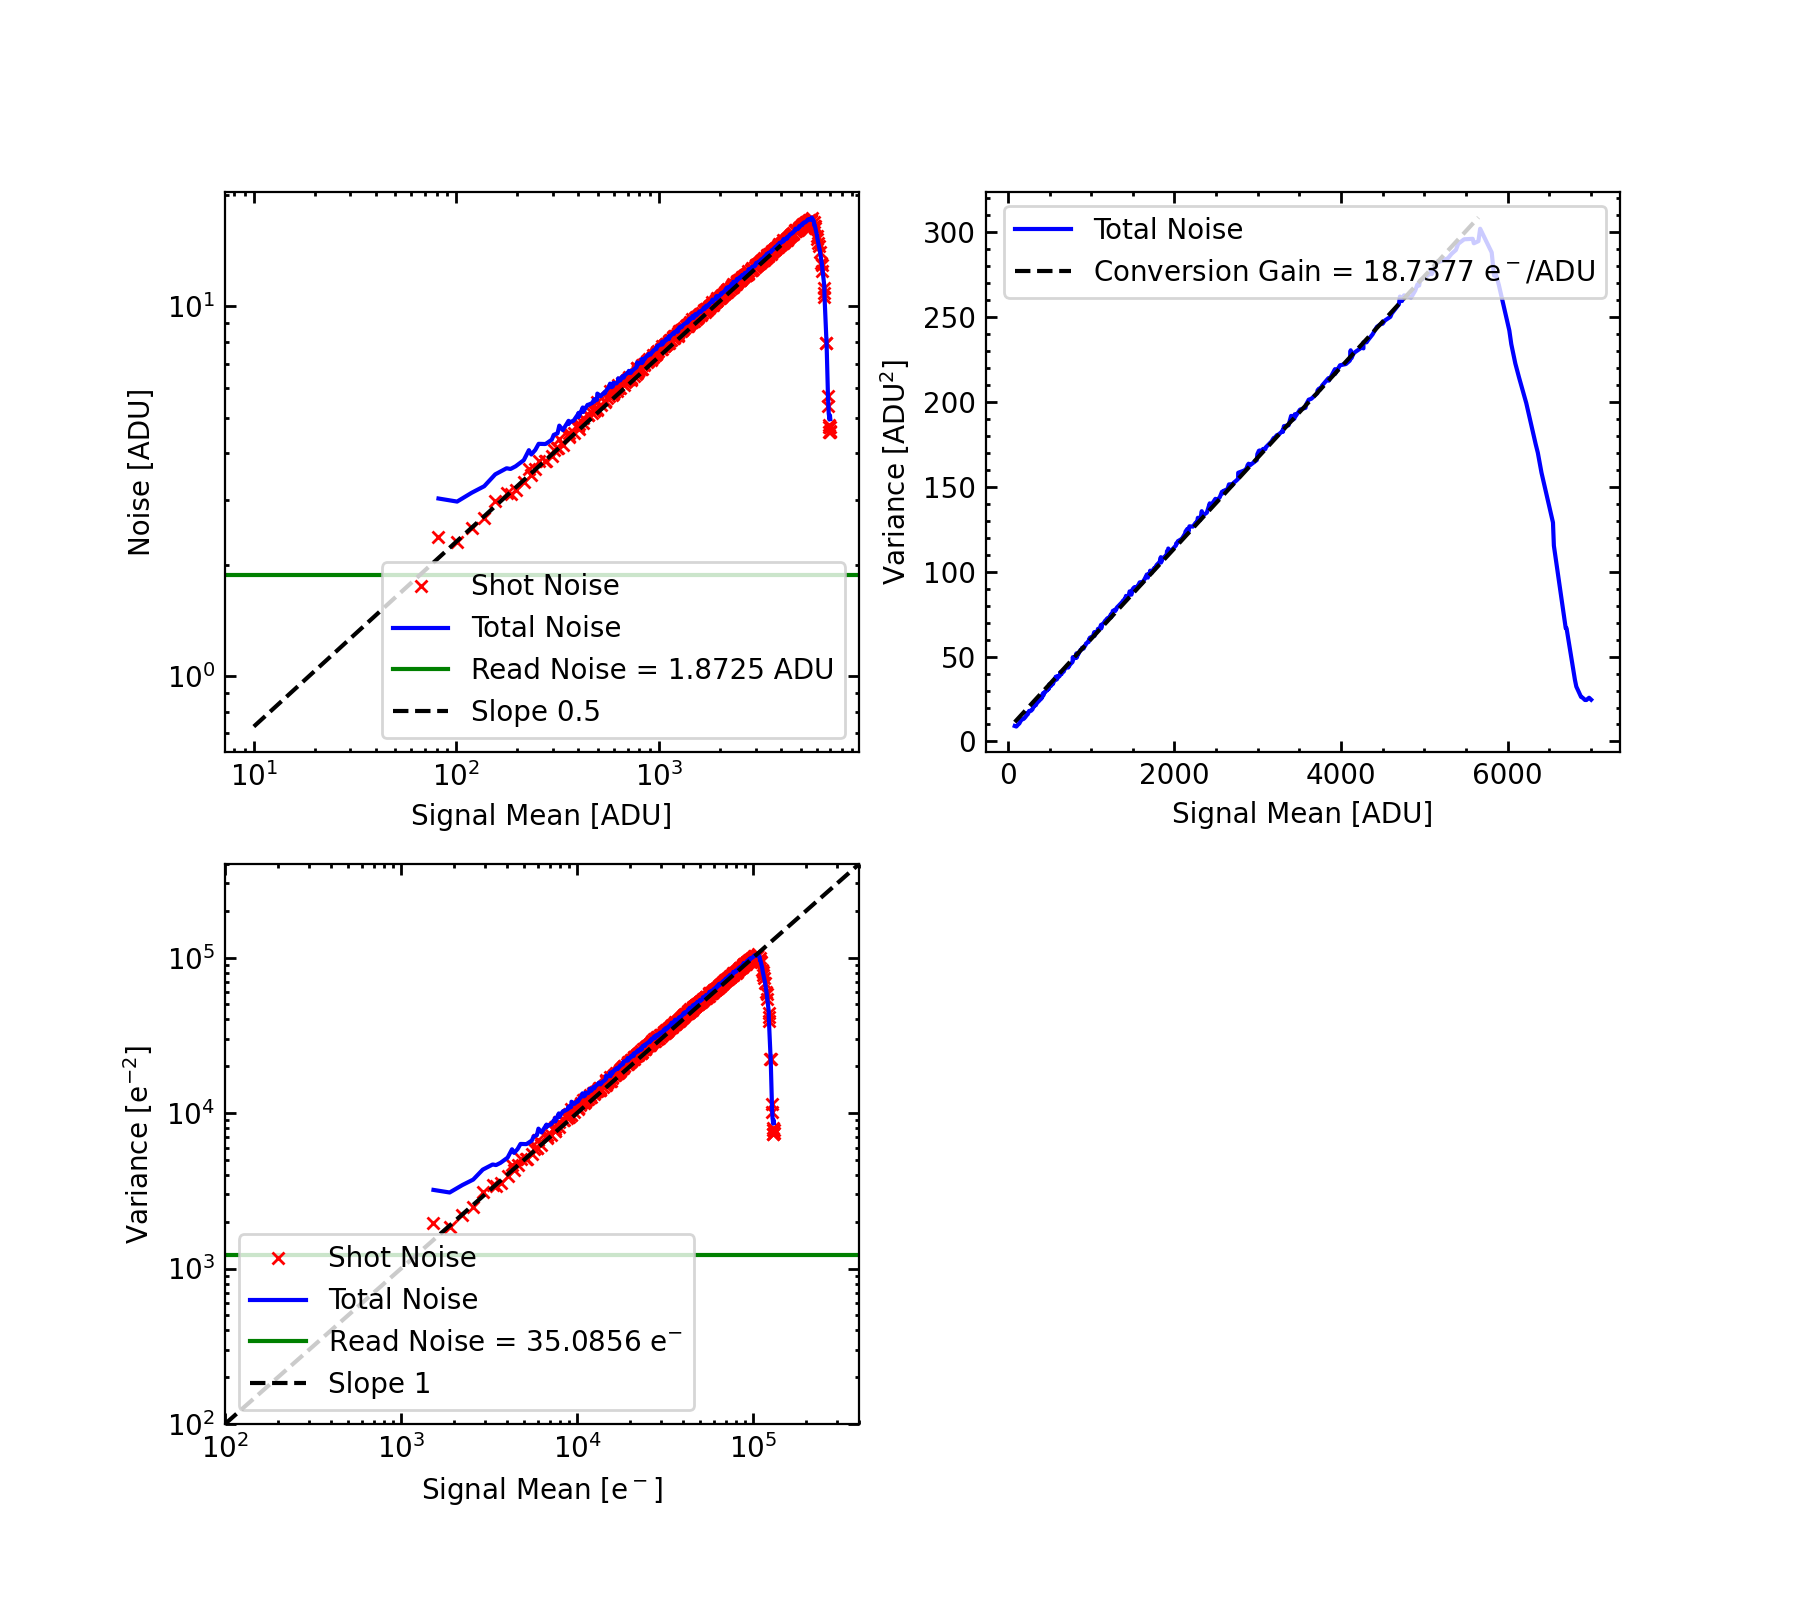

In [13]:
k = f_para1.k[0]           # conversion gain
RN = f_para2.RN[0] * k     # read noise in ADU units, f_para2.RN[0] read noise in electron units


plt.figure(figsize = (9, 8))
plt.subplot(2, 2, 1)
plt.plot(signal_sort, np.sqrt(variance_sort - RN ** 2), color = 'red', marker = 'x', markersize = 4, linestyle = 'None', label = 'Shot Noise')
plt.plot(signal_sort, np.sqrt(variance_sort), color = 'blue', label = 'Total Noise')
plt.axhline(y = RN, color = 'green', label = 'Read Noise = %.4f ADU' % (RN))
plt.plot(range(10, 4000), np.sqrt(k * range(10, 4000)), color = 'black', linestyle = '--', label = 'Slope 0.5')
#plt.ylim(1.5, 9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Signal Mean [ADU]')
plt.ylabel('Noise [ADU]')
#plt.title('PTC, Mean - Standard Deviation')
plt.tick_params(axis = 'both', top = True, right = True, direction='in', length=4, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
plt.minorticks_on()
plt.tick_params(axis = 'both', which = 'minor', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(signal_sort, variance_sort, color = 'blue', label = 'Total Noise')
plt.plot(signal_sort[:mask_idx], f_para1(signal_sort[:mask_idx]), color = 'black', linestyle = '--', label = 'Conversion Gain = %.4f e$^-$/ADU' % (1/k))
#plt.plot(signal_sort[:mask_idx], f_para(signal_sort[:mask_idx]), color = 'red', linestyle = '--')
plt.xlabel('Signal Mean [ADU]')
plt.ylabel('Variance [ADU$^2$]')
# plt.xscale('log')
# plt.yscale('log')
#plt.title('PTC, Mean - Variance')
plt.tick_params(axis = 'both', top = True, right = True, direction='in', length=4, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
plt.minorticks_on()
plt.tick_params(axis = 'both', which = 'minor', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(signal_sort / k, (variance_sort - RN ** 2) / k ** 2, color = 'red', marker = 'x', markersize = 4, linestyle = 'None', label = 'Shot Noise')
plt.plot(signal_sort / k, variance_sort / k ** 2, color = 'blue', label = 'Total Noise')
plt.axhline(y = (RN / k) ** 2, color = 'green', label = 'Read Noise = %.4f e$^{-}$' % (RN / k))
plt.axline((0, 0), slope = 1, color = 'black', linestyle = '--', label = 'Slope 1')
plt.xlim(1e2, 4e5)
plt.ylim(1e2, 4e5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Signal Mean [e$^-$]')
plt.ylabel('Variance [e$^{-2}$]')
#plt.title('PTC, Mean - Standard Deviation')
plt.tick_params(axis = 'both', top = True, right = True, direction='in', length=4, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
plt.minorticks_on()
plt.tick_params(axis = 'both', which = 'minor', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
plt.legend()

# plt.subplot(2, 2, 4)
# plt.scatter(signallist, gainlist)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Signal Mean [e$^-$]')
# plt.ylabel('Conversion Gain [ADU/e$^{-}$]')
# #plt.title('PTC, Mean - Standard Deviation')
# plt.tick_params(axis = 'both', top = True, right = True, direction='in', length=4, width=1, colors='black',
#                grid_color='black', grid_alpha=0.5)
# plt.minorticks_on()
# plt.tick_params(axis = 'both', which = 'minor', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
#                grid_color='black', grid_alpha=0.5)
# plt.legend()



In [17]:
1/0.0235

42.5531914893617

In [3]:
np.sqrt(k)

NameError: name 'np' is not defined